Each models is required to generate a stack ranking of all properties listed for sale in the database.

This script runs daily, reads in CSV files with a sorted order of homes (most attractive at the top to least attractive at the bottom), and a 'ypred' variable that reflects the scripts absolute metric (like P&L or probability of sale).

The script compares each list with homes that were sold, and identifies closed transactions ('positives') as well as the top 10 properties that each model identified that didn't sell ('negatives'). The remainder is considered 'control set'. 

For the overall data set, and specifically for each of those 3 groups, we output the average 'ypred' value, what number and percentage of homes sold from each.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import os
from slacker import Slacker
import json
import requests
from cloudinary.uploader import upload
from cloudinary.utils import cloudinary_url
from cloudinary.api import delete_resources_by_tag, resources_by_tag

csv_path = '/home/ilya/Code/rentalnerd/scraper/'
today = dt.date.today()


%matplotlib inline
        
# slack secrets (in your ~/.bashrc)
webhook_url = os.environ.get('SLACK_URL')
slacker = Slacker(os.environ.get('SLACK_TOKEN'))

# how old a target list to compare to the current target list
lag_days = 1

pd.set_option('display.max_colwidth', -1)
discount = 0.050

# to remove all the random far away areas - PHX only
zipcode_list = ['85006', '85007', '85008', '85009', '85013', '85015', '85016', '85017',
       '85018', '85019', '85020', '85021', '85022', '85023', '85024',
       '85027', '85028', '85029', '85031', '85033', '85035', '85037',
       '85040', '85041', '85043', '85044', '85048', '85050', '85051',
       '85053', '85085', '85086', '85087', '85118', '85138', '85139',
       '85142', '85143', '85202', '85203', '85204', '85205', '85206',
       '85207', '85209', '85210', '85212', '85213', '85215', '85224',
       '85225', '85226', '85233', '85234', '85248', '85249', '85250',
       '85251', '85253', '85254', '85255', '85257', '85258', '85262',
       '85266', '85286', '85295', '85296', '85297', '85298', '85301',
       '85302', '85303', '85304', '85305', '85306', '85308', '85310',
       '85323', '85326', '85331', '85335', '85339', '85340', '85351',
       '85353', '85355', '85373', '85374', '85375', '85382', '85383',
       '85388', '85390', '85392', '85396', '85704', '85705', '85706',
       '85711', '85712']

In [2]:
def plot_rounds(plot):
    # uploads the graph to the web and returns the URL
    
    fig = plot.get_figure()
    fig.tight_layout()
    fig.savefig('temp_plot.png')
    
    response = upload("temp_plot.png")
    url, options = cloudinary_url(response['public_id'],
        format = response['format'],
        crop = "fill")
    return url

In [3]:
def slack(text, url = None, title = None):
    print("Slacking: " + text)
    
    if url == None:
        data=json.dumps({"text": text})
    else:
        data = json.dumps( { "text": text, "attachments": [ { "fallback": "Model MAE"
                                           , "title": title
                                           , "image_url": url } ] } )
    
    response = requests.post(webhook_url, data , headers={'Content-Type': 'application/json'})
    if response.status_code != 200:
        raise ValueError('Request to slack returned an error %s, the response is:\n%s' % (response.status_code, response.text))


In [4]:
closed = pd.read_csv('CSV_backups/ALL-sales.csv',nrows=10000000, index_col=['property_id','transaction_id'])

In [5]:
closed.head()

,,price,transaction_status,date_listed,date_closed,days_on_market,transaction_type,price_listed,price_closed,date_transacted_latest,fsbo,...,school_district_id_68.0,school_district_id_75.0,school_district_id_76.0,school_district_id_8.0,school_district_id_87.0,school_district_id_90.0,school_district_id_93.0,school_district_id_95.0,school_district_id_96.0,school_district_id_nan
property_id,transaction_id,,,,,,,,,,,,,,,,,,,,,
8976549,22433574,190000,closed,NaN,6386,NaN,sales,NaN,190000.0,2017-06-26,NaN,...,0,0,0,0,0,0,0,0,0,0
437194,22433423,77600,closed,2011-07-01,4413,214.0,sales,65000.0,77600.0,2012-01-31,NaN,...,0,0,0,0,0,0,0,0,0,0
427521,22433143,155000,closed,NaN,6383,NaN,sales,NaN,155000.0,2017-06-23,NaN,...,0,0,0,0,0,0,0,0,0,0
8980464,22433101,278837,closed,NaN,2238,NaN,sales,NaN,278837.0,2006-02-16,NaN,...,0,0,0,0,0,0,0,0,0,0
8980462,22433099,92225,closed,NaN,-4147,NaN,sales,NaN,92225.0,1988-08-24,NaN,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# read in prior target list for backtesting purposes
prior_target_list = pd.read_csv(csv_path + 'good_sell/gs_target_list_' + (today-dt.timedelta(days=lag_days)) \
                                .strftime('%Y%m%d') + '.csv', index_col = [0,1]) \
                                .rename(columns = { 'ypred' : 'good_sell_prob'})
try:
    backtest = prior_target_list.join(closed[['price']], how="inner").sort_values(by='good_sell_prob',ascending=False)
    backtest['good_sell'] = (backtest.price >= (backtest.list * (1-discount)))
    y_all = prior_target_list.good_sell_prob.mean()
    y_sold = backtest.good_sell_prob.mean()

    pos_trigger = 0.6
    slack("Prior target list length: %i\tNum sold: %i\tAvg good sell prob: %f\tAvg good sell prob of sold: %f" 
          % (len(prior_target_list.index), len(backtest.index),y_all, y_sold))

    num_pos = len(prior_target_list[prior_target_list.good_sell_prob > pos_trigger].index)
    positives = backtest[backtest.good_sell_prob > pos_trigger]
    y_pos = (-(positives.price - positives.list) / positives.list).mean()
    num_sold = len(positives.index)
    if num_sold == 0:
        slack("Num of homes with good_sell_prob > %f: %i\tPerc of those sold: NONE\tAvg disc to list: NA" % (pos_trigger, num_pos) )    
    else:
        slack("Num of homes with good_sell_prob > %f: %i\tPerc of those sold: %f\tAvg disc to list: %f" 
              % (pos_trigger, num_pos, num_sold / num_pos *  100, y_pos * 100))

    neg_trigger = 0.3
    num_neg = len(prior_target_list[prior_target_list.good_sell_prob < neg_trigger].index)
    negatives = backtest[backtest.good_sell_prob < neg_trigger]
    y_neg = (-(negatives.price - negatives.list) / negatives.list).mean()
    num_sold = len(negatives.index)

    if num_sold == 0:
        slack("Num of homes with good_sell_prob < %f: %i\tPerc of those sold: NONE\tAvg disc to list: NA" % (neg_trigger, num_neg))
    else:
        slack("Num of homes with good_sell_prob < %f: %i\tPerc of those sold: %f\tAvg disc to list:%f" 
              % (neg_trigger, num_neg, len(negatives.index) / num_neg * 100, y_neg * 100))

    slack(backtest.to_string())
except Exception as err:   
    slack("No homes sold since last run")

Slacking: Prior target list length: 9874	Num sold: 6	Avg good sell prob: 0.491026	Avg good sell prob of sold: 0.496417
Slacking: Num of homes with good_sell_prob > 0.600000: 0	Perc of those sold: NONE	Avg disc to list: NA
Slacking: Num of homes with good_sell_prob < 0.300000: 0	Perc of those sold: NONE	Avg disc to list: NA
Slacking:                                                               address  zipcode  good_sell_prob    list                                                                                      url   price good_sell
property_id transaction_id                                                                                                                                                                                       
70463       22396825        3687 S Dew Drop Ln, Gilbert, AZ 85297      85297    0.508719        309000  https://www.zillow.com/homedetails/3687-S-Dew-Drop-Ln-Gilbert-AZ-85297/82799824_zpid/    309000  True    
72631       22397260        3990 E 

In [7]:
# read in prior target list for backtesting purposes
prior_target_list = pd.read_csv(csv_path + 'value_buy/vb_target_list_' + (today-dt.timedelta(days=lag_days)) \
                                .strftime('%Y%m%d') + '.csv', index_col = [0,1]) \
                                .rename(columns = { 'ypred' : 'pnl'})

try:
    backtest = prior_target_list.join(closed['price'], how="inner").sort_values(by='pnl',ascending=False)
    backtest['good_sell'] = (backtest.price >= (backtest.list * (1-discount)))
    avg_pnl = backtest.pnl.mean()
    predicted_price = backtest.predicted_price.mean()
    sale_price = backtest.price.mean()

    slack("Prior target list length: %i\tNum sold: %i\tAvg P&L: %f\tAvg predict price: %f\tAvg sale price: %f" 
          % (len(prior_target_list.index), len(backtest.index),y_all, predicted_price, sale_price))

    pos_trigger = -10000
    num_pos = len(prior_target_list[prior_target_list.pnl > pos_trigger].index)
    positives = backtest[backtest.pnl > pos_trigger]
    y_pos = (-(positives.price - positives.list) / positives.list).mean()
    num_sold = len(positives.index)
    if num_sold == 0:
        slack("Num of homes with pnl > %f: %i\tPerc of those sold: NONE\tAvg disc to list: NA" % (pos_trigger, num_pos) )    
    else:
        slack("Num of homes with pnl > %f: %i\tPerc of those sold: %f\tAvg disc to list: %f" 
              % (pos_trigger, num_pos, num_sold / num_pos, y_pos))

    neg_trigger = -30000
    num_neg = len(prior_target_list[prior_target_list.pnl < neg_trigger].index)
    negatives = backtest[backtest.pnl < neg_trigger]
    y_neg = (-(negatives.price - negatives.list) / negatives.list).mean()
    num_sold = len(negatives.index)

    if num_sold == 0:
        slack("Num of homes with pnl < %f: %i\tPerc of those sold: NONE\tAvg disc to list: NA" % (neg_trigger, num_neg))
    else:
        slack("Num of homes with pnl < %f: %i\tPerc of those sold: %f\tAvg disc to list:%f" 
              % (neg_trigger, num_neg, len(negatives.index) / num_neg, y_neg))

    slack(backtest.to_string())
except Exception as err:   
    slack("No homes sold since last run")

Slacking: Prior target list length: 9874	Num sold: 6	Avg P&L: 0.491026	Avg predict price: 144685.621094	Avg sale price: 275750.000000
Slacking: Num of homes with pnl > -10000.000000: 103	Perc of those sold: NONE	Avg disc to list: NA
Slacking: Num of homes with pnl < -30000.000000: 9648	Perc of those sold: 0.000622	Avg disc to list:0.003367
Slacking:                                                               address  zipcode            pnl  predicted_price    list                                                                                      url   price good_sell
property_id transaction_id                                                                                                                                                                                                       
1099012     22386998        966 N Dakota St, Chandler, AZ 85225        85225   -66226.390625   143773.609375    210000  https://www.zillow.com/homedetails/966-N-Dakota-St-Chandler-AZ-85225/8187107

In [8]:
vb = pd.read_csv('value_buy/vb_target_list_' + today.strftime('%Y%m%d') + '.csv', index_col = ['property_id','transaction_id']) \
       .drop(['address','zipcode', 'url','list'],axis=1) \
       .rename(columns = { 'ypred': 'pnl'}) \
       .drop_duplicates()
    
gs = pd.read_csv('good_sell/gs_target_list_'  + today.strftime('%Y%m%d') + '.csv', index_col = ['property_id','transaction_id'])  \
       .rename(columns = { 'ypred' : 'good_sell_prob'}) \
       .drop_duplicates()
        
vb = vb[~vb.index.duplicated(keep='first')]
gs = gs[~gs.index.duplicated(keep='first')]
    
print("Len of value buy\t%i" % len(vb.index))
print("Len of good sell\t%i" % len(gs.index))

c = pd.concat([vb,gs],axis=1, join='inner')

c['pnl_percent'] = (c.pnl / c.list)

c = c[(c.list < 250000) & (c.list > 100000)  \
      & (~c.address.str.contains("Rent|rent|LOT|#|Sun City"))] 

Len of value buy	10145
Len of good sell	10150


/home/ilya/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Slacking: 


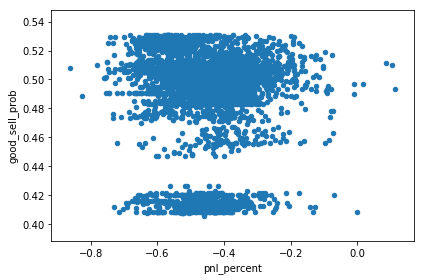

In [9]:
url = plot_rounds(c.query('good_sell_prob > 0.00').plot.scatter(x='pnl_percent', y='good_sell_prob'))
slack("", url, "Model Correlation")

In [15]:
# ran both data datasets and combine to create an equally weighted ensemble ranking
c["pnl_rank"] = c.pnl.rank(ascending=False)
c["gs_rank"] = c.good_sell_prob.rank(ascending=False)
c["rank"] = (c.pnl_rank + c.gs_rank)
c["zipcode"] = c.zipcode.apply(str)

# filter the output to remove duds
d = c[(c.pnl_percent > -0.2) & (c.good_sell_prob > 0.4) & (c.zipcode.isin(zipcode_list))]

d = c.sort("rank").nsmallest(20, "gs_rank")

file = csv_path + 'ensemble/comb_target_list_' + today.strftime('%Y%m%d') + '.csv'
np.round(d[['address', 'zipcode','list','predicted_price','pnl_percent','good_sell_prob','rank','url']], 4).to_csv(file)

slacker.files.upload(file, channels='#progress')

/home/ilya/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:10: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [16]:
for_sale = pd.read_csv('CSV_backups/ALL-for_sale.csv', index_col=['property_id','transaction_id'])
for_sale['zipcode'] = for_sale.zipcode.apply(str)

In [17]:
from math import radians, cos, sin, asin, sqrt
def haversine(row, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    lon1 = row.longitude
    lat1 = row.latitude
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    return km / 1.60934 # convert to miles

In [18]:
for r, target in d.iterrows():
    print(target.name[0])
    print(target.address)
    target.longitude = for_sale.loc[target.name].longitude
    target.latitude = for_sale.loc[target.name].latitude
    
    # get all properties listed for sale in the same zipcode as our target
    z = for_sale[(for_sale.zipcode == target.zipcode)]
    print(len(z.longitude))
    
    z['dist'] = z.apply(haversine, lon2 = target.longitude, lat2 = target.latitude, axis=1)
    print(z[['address','dist']].nsmallest(5,'dist'))
    

1406908
6810 N 77th Ave, Glendale, AZ 85303 
76
                                                            address      dist
property_id transaction_id                                                   
1406908     21989550        6810 N 77th Ave, Glendale, AZ 85303      0.000000
5356902     8441236         6807 N 77th Dr # 0, Glendale, AZ 85303   0.020715
1417523     22345379        7726 W Ocotillo Rd, Glendale, AZ 85303   0.096670
1416282     22391439        7588 W Ocotillo Rd, Glendale, AZ 85303   0.145974
1410205     21990050        7035 N 77th Dr, Glendale, AZ 85303       0.151910
942560
719 S 223rd Ln, Buckeye, AZ 85326 
330


/home/ilya/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/ilya/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
/home/ilya/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


                                                             address      dist
property_id transaction_id                                                    
942560      21990278        719 S 223rd Ln, Buckeye, AZ 85326         0.000000
919404      21973018        22338 W Antelope Trl, Buckeye, AZ 85326   0.089933
7420096     21992237        951 S 224th Ln, Buckeye, AZ 85326         0.196221
918559      16074842        22223 W Lasso Ln, Buckeye, AZ 85326       0.208950
908274      22422738        1030 S 223rd Ln, Buckeye, AZ 85326        0.214055
919404
22338 W Antelope Trl, Buckeye, AZ 85326 
330
                                                             address      dist
property_id transaction_id                                                    
919404      21973018        22338 W Antelope Trl, Buckeye, AZ 85326   0.000000
942560      21990278        719 S 223rd Ln, Buckeye, AZ 85326         0.089933
918559      16074842        22223 W Lasso Ln, Buckeye, AZ 85326       0.124967


In [14]:
d

,,pnl,predicted_price,address,zipcode,good_sell_prob,list,url,pnl_percent,pnl_rank,gs_rank,rank
property_id,transaction_id,,,,,,,,,,,
1406908,21989550,-78322.265625,154676.734375,"6810 N 77th Ave, Glendale, AZ 85303",85303,0.530589,232999,https://www.zillow.com/homedetails/6810-N-77th-Ave-Glendale-AZ-85303/7463194_zpid/,-0.336149,1331.0,17.5,1348.5
942560,21990278,-79955.796875,135044.203125,"719 S 223rd Ln, Buckeye, AZ 85326",85326,0.530589,215000,https://www.zillow.com/homedetails/719-S-223rd-Ln-Buckeye-AZ-85326/67787102_zpid/,-0.371887,1424.0,17.5,1441.5
919404,21973018,-85845.234375,117154.765625,"22338 W Antelope Trl, Buckeye, AZ 85326",85326,0.530589,203000,https://www.zillow.com/homedetails/22338-W-Antelope-Trl-Buckeye-AZ-85326/67796800_zpid/,-0.422883,1768.0,17.5,1785.5
908211,21817164,-86912.828125,116987.171875,"1018 S 222nd Ln, Buckeye, AZ 85326",85326,0.530589,203900,https://www.zillow.com/homedetails/1018-S-222nd-Ln-Buckeye-AZ-85326/71617613_zpid/,-0.426252,1830.0,17.5,1847.5
130901,21957236,-87399.703125,147600.296875,"15051 W Rockrose Way, Surprise, AZ 85374",85374,0.530589,235000,https://www.zillow.com/homedetails/15051-W-Rockrose-Way-Surprise-AZ-85374/8122965_zpid/,-0.371914,1860.0,17.5,1877.5
7485224,21957925,-99726.687500,125173.312500,"4830 W Donner Dr, Laveen, AZ 85339",85339,0.530589,224900,https://www.zillow.com/homedetails/4830-W-Donner-Dr-Laveen-AZ-85339/81954212_zpid/,-0.443427,2621.0,17.5,2638.5
1483892,21930376,-102869.234375,114030.765625,"18065 N 113th Ave, Surprise, AZ 85378",85378,0.530589,216900,https://www.zillow.com/homedetails/18065-N-113th-Ave-Surprise-AZ-85378/52426025_zpid/,-0.474270,2807.0,17.5,2824.5
524890,22104506,-103533.375000,146366.625000,"9133 W Vernon Ave, Phoenix, AZ 85037",85037,0.530589,249900,https://www.zillow.com/homedetails/9133-W-Vernon-Ave-Phoenix-AZ-85037/67764436_zpid/,-0.414299,2839.0,17.5,2856.5
8955871,21959396,-105366.328125,144433.671875,"6929 W Sophie Ln, Laveen, AZ 85339",85339,0.530589,249800,https://www.zillow.com/homedetails/6929-W-Sophie-Ln-Laveen-AZ-85339/81981174_zpid/,-0.421803,2937.0,17.5,2954.5
